In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer

In [5]:
%%time
df = pd.read_csv('/Volumes/Mohs\'s_SSD/DeepLearning Models/DataSets/Predicting_Exoplanet_Habitability/hwc.csv')

CPU times: user 39.7 ms, sys: 8.3 ms, total: 48 ms
Wall time: 47.3 ms


Understanding the Data

In [6]:
df.head()
df.shape

(5599, 118)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5599 entries, 0 to 5598
Columns: 118 entries, P_NAME to S_CONSTELLATION_ENG
dtypes: float64(81), int64(18), object(19)
memory usage: 5.0+ MB


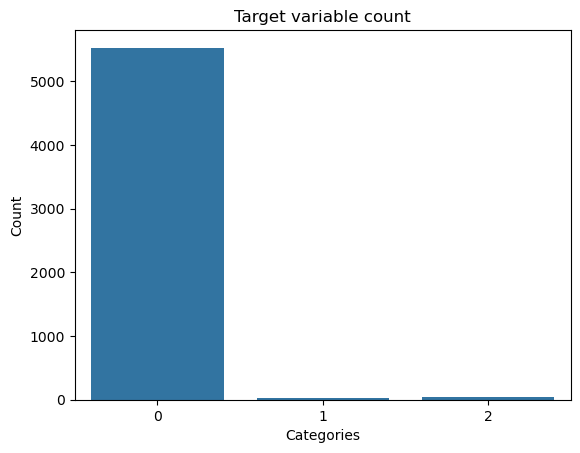

In [8]:
x = df['P_HABITABLE'].value_counts().values
y = df['P_HABITABLE'].value_counts().index

sns.barplot(x=y, y=x)  # Correct usage
plt.title('Target variable count')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

In [ ]:
y = df['P_HABITABLE'].astype('uint8')
X = df.drop(['P_HABITABLE'], axis=1)

print(X.shape)
print(y.shape)

(5599, 117)
(5599,)


In [10]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=1)

RESAMPLING DUE TO UNBALANCED DATA SETS

Uh: Unhabitable           --> 0
Ph: Potentially Habitable --> 1
Ch: Confirmed Habitable    --> 2

In [11]:
X = pd.concat([X_train,y_train],axis=1)

Uh = X[X['P_HABITABLE'] == 0]
Ph = X[X['P_HABITABLE'] == 1]
Ch = X[X['P_HABITABLE'] == 2]

Ph_Upsampled = resample(Ph,
                          replace=True, # sample with replacement
                          n_samples=len(Uh), # match number in majority class
                          random_state=27)

Ch_Upsampled = resample(Ch,
                            replace=True, # sample with replacement
                            n_samples=len(Uh), # match number in majority class
                            random_state=27) # reproducible results

# combine majority and upsampled minority
Upsampled = pd.concat([Uh, Ph_Upsampled, Ch_Upsampled])
Upsampled['P_HABITABLE'].value_counts()

P_HABITABLE
0    4417
1    4417
2    4417
Name: count, dtype: int64

Text(0, 0.5, 'count')

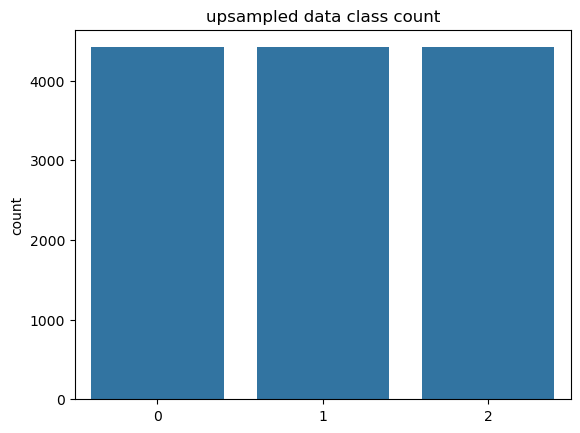

In [12]:
y = Upsampled.P_HABITABLE.value_counts()
sns.barplot(y=y,x=[0,1,2])
plt.title('upsampled data class count')
plt.ylabel('count')

In [ ]:
X_encoded = pd.get_dummies(X, drop_first=True)

In [39]:
X_encoded.shape

(4479, 24105)

HANDELING MISSING DATA

Will use SimpleImputer to Fill Nan with Mean val

In [51]:

imputer = SimpleImputer(strategy="mean")  # Replace NaN with mean
X_encoded_imputed = imputer.fit_transform(X_encoded)

DIMENSIONALITY REDUCTION:

~ Comparing 3-Methods:
    T-sne
    PCA
    Truncated SVD

In [21]:
# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_encoded_imputed)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X_encoded_imputed)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X_encoded_imputed)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

/Users/mohamedsaba/miniforge3/envs/myenv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:105: RuntimeWarning: overflow encountered in cast
  distances_data = distances_data.astype(np.float32, copy=False)
/Users/mohamedsaba/miniforge3/envs/myenv/lib/python3.10/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


T-SNE took 5.2 s
PCA took 1.5 s
Truncated SVD took 1.1 s


In [16]:
X_reduced_tsne = pd.DataFrame(X_reduced_tsne, columns=['x1', 'x2'])
X_reduced_pca = pd.DataFrame(X_reduced_pca, columns=['x1', 'x2'])
X_reduced_svd = pd.DataFrame(X_reduced_svd, columns=['x1', 'x2'])


In [42]:
X_test_run = pd.get_dummies(X, drop_first=True)

In [45]:
X_test_run = X_test_run.reindex(columns=Upsampled.columns, fill_value=0)

In [53]:
X_test_run = imputer.fit_transform(X_test_run)

In [55]:
X_test_run = pd.DataFrame(X_test_run, columns=Upsampled.columns)